This script uses geopandas to read the census information of Pittburgh.

# Installing Libraries

While most basic Python Libraries taht are used in this notebook are pre-installed on your system, you might want to install additional libraries. The following code is tested on Linux OS, Python 2.7.

You can install GeoPandas, Shapely (automatically installed as a dependency of GeoPandas), and GeoPy using pip. Additionally, you might have to install Rtree to install relevant geopandas dependency.

    $ pip install --upgrade geopandas geopy
$ conda install -c ioos rtree

To ensue that all the packages have been installed correctly, please run the following code. If error still persists, you might want to look at the original documentation for troubleshooting.

In [1]:
import geopandas as gpd
import shapely
from geopy.geocoders import GoogleV3
import rtree
import fiona

Additional libraries:

In [2]:
import os
import csv
import zipfile
import string
import pandas as pd
import datetime as dt
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")
%matplotlib inline

## Load Pittsburgh info

We download the Census_Data.zip file from the Pittsburgh city planning website: http://apps.pittsburghpa.gov/dcp/Census_Data.zip and extract Block_Group_2010.zip to get the breakdown of Pittsburgh area by census block groups.  

In [4]:
df_block_group = gpd.read_file("../Dataset/Block_Group_2010/Block_Group_2010.shp");

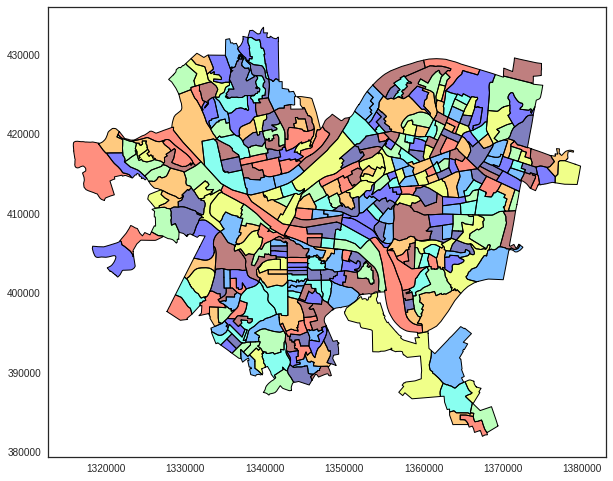

In [5]:
df_block_group.plot(figsize=(10,10), cmap="jet");

In [6]:
df_block_group.rename(columns={'GEOID10': 'GEOID'}, inplace=True)

In [7]:
df_block_group.head()

,ALAND10,AWATER10,BLKGRPCE10,COUNTYFP10,FUNCSTAT10,GEOID,INTPTLAT10,INTPTLON10,MTFCC10,NAMELSAD10,STATEFP10,Shape_Area,Shape_Leng,TRACTCE10,geometry
0,268195.0,0.0,1,003,S,420030405001,+40.4406805,-079.9542332,G5030,Block Group 1,42,2.886582e+06,7988.379131,040500,"POLYGON ((1355246.206097782 411952.6973433495,..."
1,75472.0,0.0,1,003,S,420030404001,+40.4458408,-079.9483932,G5030,Block Group 1,42,8.122733e+05,3856.087334,040400,"POLYGON ((1357218.995131195 412598.4752512723,..."
2,282679.0,0.0,2,003,S,420030402002,+40.4412437,-079.9626107,G5030,Block Group 2,42,3.042469e+06,8260.915502,040200,"POLYGON ((1352517.362802193 410240.0639576018,..."
3,284548.0,0.0,2,003,S,420030305002,+40.4403871,-079.9813476,G5030,Block Group 2,42,3.062574e+06,8237.411215,030500,"POLYGON ((1348149.846274778 411556.8736599386,..."
4,383059.0,0.0,1,003,S,420030305001,+40.4444763,-079.9855727,G5030,Block Group 1,42,4.122849e+06,10371.620190,030500,"POLYGON ((1345945.822795689 413447.4505874366,..."


In [8]:
len(df_block_group)

359

## Load Pennsylvania Block Group Data

From the American Community Survey (http://www.census.gov/geo/maps-data/data/tiger-data.html), which provides (estimated) demographic information of Pennsylvania at block group level, we get the wealth information and geocodes of for the Pittsburgh city. 

Since the data is available for Pennsylvania, we filter the data to extract records for Pittsburgh only.

In [9]:
# Set location of file
filepath = "../Dataset/ACS_2014_5YR_BG_42.gdb.zip"
filepath

'../Dataset/ACS_2014_5YR_BG_42.gdb.zip'

In [10]:
# Read geo data: COUNTYFP = 003 is for Allegheny
df_geodata = gpd.read_file(filepath)
df_geodata[df_geodata.COUNTYFP=='003'].head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,GEOID_Data,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,STATEFP,Shape_Area,Shape_Length,TRACTCE,geometry
187,185601.0,0.0,4,003,S,420031702004,15000US420031702004,+40.4269824,-079.9793259,G5030,Block Group 4,42,0.000020,0.018659,170200,(POLYGON ((-79.98254500005169 40.4255209999942...
330,4179662.0,0.0,3,003,S,420034530043,15000US420034530043,+40.4488333,-080.1901884,G5030,Block Group 3,42,0.000444,0.111142,453004,(POLYGON ((-80.21185799974683 40.4454849997330...
331,221122.0,0.0,3,003,S,420035639003,15000US420035639003,+40.4200274,-079.8459672,G5030,Block Group 3,42,0.000023,0.023156,563900,(POLYGON ((-79.85031599968357 40.4201919997610...
338,2718087.0,0.0,3,003,S,420034690003,15000US420034690003,+40.4216865,-080.0550895,G5030,Block Group 3,42,0.000288,0.103836,469000,(POLYGON ((-80.07471500029698 40.4128999998351...
451,369959.0,0.0,4,003,S,420032904004,15000US420032904004,+40.3909811,-079.9764177,G5030,Block Group 4,42,0.000039,0.036984,290400,(POLYGON ((-79.98000900001529 40.3934050001407...


In [11]:
len(df_geodata[df_geodata.COUNTYFP=='003'])

1100

In [12]:
df_pitts = pd.merge(df_geodata, df_block_group[['GEOID']],on='GEOID',how='inner')

In [13]:
len(df_pitts)

359

In [14]:
df_pitts.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,GEOID_Data,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,STATEFP,Shape_Area,Shape_Length,TRACTCE,geometry
0,185601.0,0.0,4,003,S,420031702004,15000US420031702004,+40.4269824,-079.9793259,G5030,Block Group 4,42,0.000020,0.018659,170200,(POLYGON ((-79.98254500005169 40.4255209999942...
1,369959.0,0.0,4,003,S,420032904004,15000US420032904004,+40.3909811,-079.9764177,G5030,Block Group 4,42,0.000039,0.036984,290400,(POLYGON ((-79.98000900001529 40.3934050001407...
2,138709.0,0.0,5,003,S,420035624005,15000US420035624005,+40.4197360,-079.9991617,G5030,Block Group 5,42,0.000015,0.018903,562400,(POLYGON ((-80.0023679995835 40.42109700012651...
3,168360.0,0.0,3,003,S,420030103003,15000US420030103003,+40.4368931,-079.9837605,G5030,Block Group 3,42,0.000018,0.020349,010300,(POLYGON ((-79.98678300033515 40.4351529999110...
4,1473092.0,251261.0,1,003,S,420039801001,15000US420039801001,+40.4798795,-079.9165548,G5030,Block Group 1,42,0.000183,0.085458,980100,(POLYGON ((-79.92751500021706 40.4808350003350...


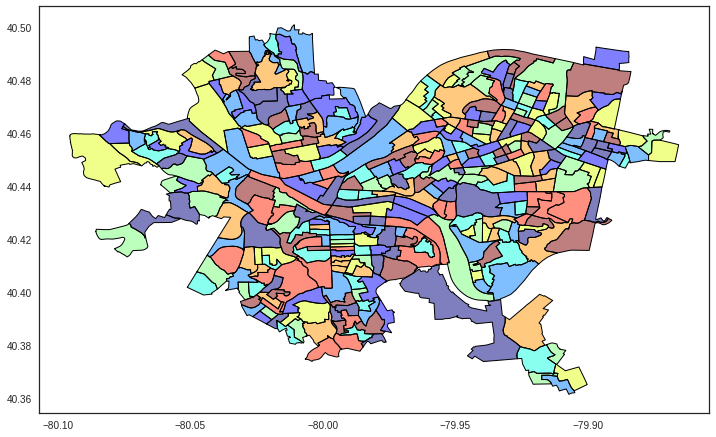

In [15]:
df_pitts.plot(figsize=(12,12), cmap="jet")

In [16]:
# Getting boundary value for Pittsburgh
df_pitts.geometry.total_bounds

(-80.095508999640572,
 40.361565999571269,
 -79.865794000292851,
 40.501037000257384)

In [17]:
min(df_pitts.geometry.bounds.minx), min(df_pitts.geometry.bounds.miny)

(-80.095508999640572, 40.361565999571269)

In [18]:
max(df_pitts.geometry.bounds.maxx), max(df_pitts.geometry.bounds.maxy)

(-79.865794000292851, 40.501037000257384)

In [19]:
df_pitts[['minx','miny','maxx','maxy']]=df_pitts.bounds

In [20]:
df_pitts.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,GEOID_Data,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,STATEFP,Shape_Area,Shape_Length,TRACTCE,geometry,minx,miny,maxx,maxy
0,185601.0,0.0,4,003,S,420031702004,15000US420031702004,+40.4269824,-079.9793259,G5030,Block Group 4,42,0.000020,0.018659,170200,(POLYGON ((-79.98254500005169 40.4255209999942...,-79.982592,40.425126,-79.976265,40.428835
1,369959.0,0.0,4,003,S,420032904004,15000US420032904004,+40.3909811,-079.9764177,G5030,Block Group 4,42,0.000039,0.036984,290400,(POLYGON ((-79.98000900001529 40.3934050001407...,-79.980045,40.384792,-79.973035,40.396970
2,138709.0,0.0,5,003,S,420035624005,15000US420035624005,+40.4197360,-079.9991617,G5030,Block Group 5,42,0.000015,0.018903,562400,(POLYGON ((-80.0023679995835 40.42109700012651...,-80.002486,40.417413,-79.997249,40.421775
3,168360.0,0.0,3,003,S,420030103003,15000US420030103003,+40.4368931,-079.9837605,G5030,Block Group 3,42,0.000018,0.020349,010300,(POLYGON ((-79.98678300033515 40.4351529999110...,-79.986783,40.434982,-79.979542,40.438607
4,1473092.0,251261.0,1,003,S,420039801001,15000US420039801001,+40.4798795,-079.9165548,G5030,Block Group 1,42,0.000183,0.085458,980100,(POLYGON ((-79.92751500021706 40.4808350003350...,-79.927573,40.467410,-79.905354,40.488237


## Load Wealth Info

In [21]:
fiona.listlayers(filepath)

[u'ACS_2014_5YR_BG_42_PENNSYLVANIA',
 u'BG_METADATA_2014',
 u'X00_COUNTS',
 u'X01_AGE_AND_SEX',
 u'X02_RACE',
 u'X03_HISPANIC_OR_LATINO_ORIGIN',
 u'X07_MIGRATION',
 u'X08_COMMUTING',
 u'X09_CHILDREN_HOUSEHOLD_RELATIONSHIP',
 u'X11_HOUSEHOLD_FAMILY_SUBFAMILIES',
 u'X12_MARITAL_STATUS_AND_HISTORY',
 u'X14_SCHOOL_ENROLLMENT',
 u'X15_EDUCATIONAL_ATTAINMENT',
 u'X16_LANGUAGE_SPOKEN_AT_HOME',
 u'X17_POVERTY',
 u'X19_INCOME',
 u'X20_EARNINGS',
 u'X21_VETERAN_STATUS',
 u'X22_FOOD_STAMPS',
 u'X23_EMPLOYMENT_STATUS',
 u'X24_INDUSTRY_OCCUPATION',
 u'X25_HOUSING_CHARACTERISTICS',
 u'X27_HEALTH_INSURANCE',
 u'X99_IMPUTATION']

Metadata of column shortnames

In [22]:
df_metadata = gpd.read_file(filepath, layer="BG_METADATA_2014");
df_metadata.head()

,Full_Name,Short_Name,geometry
0,UNWEIGHTED SAMPLE COUNT OF THE POPULATION: Tot...,B00001e1,None
1,UNWEIGHTED SAMPLE COUNT OF THE POPULATION: Tot...,B00001m1,None
2,UNWEIGHTED SAMPLE HOUSING UNITS: Total: Housin...,B00002e1,None
3,UNWEIGHTED SAMPLE HOUSING UNITS: Total: Housin...,B00002m1,None
4,SEX BY AGE: Total: Total population -- (Estimate),B01001e1,None


In [23]:
len(df_metadata)

7706

Income data for tracts

In [24]:
df_income = gpd.read_file(filepath, layer="X19_INCOME");
df_income.head()

,B19001e1,B19001e10,B19001e11,B19001e12,B19001e13,B19001e14,B19001e15,B19001e16,B19001e17,B19001e2,...,B19313Ge1,B19313Gm1,B19313He1,B19313Hm1,B19313Ie1,B19313Im1,B19313e1,B19313m1,GEOID,geometry
0,952,39,87,143,192,136,72,64,38,20,...,NaN,NaN,87649500.0,12194336.0,1394200.0,1985524.0,89526300.0,11591285.0,15000US420010301011,None
1,439,13,65,104,70,24,0,0,0,0,...,NaN,NaN,23714300.0,5668772.0,2701100.0,3823917.0,26415400.0,6655688.0,15000US420010301021,None
2,974,77,67,177,163,158,78,71,41,0,...,NaN,NaN,95012600.0,23445771.0,NaN,NaN,97127700.0,23341893.0,15000US420010301022,None
3,781,30,112,66,149,32,47,0,17,14,...,NaN,NaN,47288800.0,10932066.0,NaN,NaN,47370200.0,10937212.0,15000US420010301023,None
4,1184,48,157,60,223,117,54,23,9,21,...,873200.0,891594.0,64904700.0,6142012.0,4630900.0,2452538.0,73413200.0,6789943.0,15000US420010302001,None


In [25]:
len(df_income)

9740

Selecting 1/458 column from income df that best describes the wealth level of a tract

In [26]:
fullname = []
for colname in df_income.columns:
    fullname.extend(df_metadata.Full_Name[df_metadata.Short_Name == colname].values)

In [27]:
fullname[:2]

[u'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS): Total: Households -- (Estimate)',
 u'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS): $45,000 to $49,999: Households -- (Estimate)']

In [28]:
sub = 'ALONE'
sub1 = 'HISPANIC OR LATINO'
sub2 = 'RACE'
sub3 = 'FAMILY'
sub4 = 'BY'
temp = []
names = []
shortname = []
for val in fullname:
    if sub not in val and \
        sub1 not in val and \
        sub2 not in val and \
        sub3 not in val and \
        sub4 not in val and \
        '$' not in val and \
        'Quintile' not in val and \
        'Estimate' in val and \
        'Total' in val and \
        'DIVIDENDS' not in val and \
        'OTHER' not in val and \
        'ASSISTANCE' not in val and \
        'RETIREMENT' not in val and \
        'EMPLOYMENT' not in val and \
        'SUPPLEMENTAL' not in val and \
        'SECURITY' not in val and \
        'WAGE' not in val and \
        '(IN 2014 INFLATION-ADJUSTED DOLLARS)' in val:
        index = val.index('IN THE PAST')
        names.append(val)
        shortname.extend(df_metadata.Short_Name[df_metadata.Full_Name == val].values)

In [29]:
len(names)

6

In [30]:
shortname

[u'B19001e1', u'B19013e1', u'B19025e1', u'B19061e1', u'B19301e1', u'B19313e1']

In [31]:
df_metadata[df_metadata.Short_Name.isin(shortname)]

,Full_Name,Short_Name,geometry
3236,HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 201...,B19001e1,None
3270,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,B19013e1,None
3290,AGGREGATE HOUSEHOLD INCOME IN THE PAST 12 MONT...,B19025e1,None
3522,AGGREGATE EARNINGS IN THE PAST 12 MONTHS (IN 2...,B19061e1,None
3652,PER CAPITA INCOME IN THE PAST 12 MONTHS (IN 20...,B19301e1,None
3672,AGGREGATE INCOME IN THE PAST 12 MONTHS (IN 201...,B19313e1,None


In [32]:
for n in names:
    print n, '\n'

HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS): Total: Households -- (Estimate) 

MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS): Total: Households -- (Estimate) 

AGGREGATE HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS): Total: Households -- (Estimate) 

AGGREGATE EARNINGS IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS) FOR HOUSEHOLDS: Total: Households -- (Estimate) 

PER CAPITA INCOME IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS): Total: Total population -- (Estimate) 

AGGREGATE INCOME IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS): Total: Population 15 years and over -- (Estimate) 



In [33]:
df_income[shortname].head()

,B19001e1,B19013e1,B19025e1,B19061e1,B19301e1,B19313e1
0,952,79048.0,89068400.0,73286700.0,34579.0,89526300.0
1,439,58880.0,25523100.0,21215900.0,19155.0,26415400.0
2,974,81471.0,96624700.0,80125700.0,38882.0,97127700.0
3,781,55754.0,46918300.0,34525700.0,24736.0,47370200.0
4,1184,52125.0,73528600.0,57685900.0,23590.0,73413200.0


### Here, we plan to choose 'B19013e1': MEDIAN HOUSEHOLD INCOME

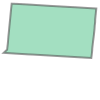

In [34]:
df_pitts.geometry[0]

In [35]:
# Returns a DataFrame with columns minx, miny, maxx, maxy values containing the bounds for each geometry.
df_pitts.geometry[0].bounds

(-79.98259200042042, 40.42512599976516, -79.97626500002968, 40.42883499993536)

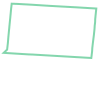

In [36]:
df_pitts.geometry[0].boundary

In [37]:
df_pitts.geometry[0].centroid.bounds[:2]

(-79.97932585407285, 40.42698243878276)

# Final DF

In [38]:
df_final= pd.DataFrame()

In [39]:
df_final['GEOID'] = df_pitts.GEOID_Data

In [40]:
df_final['Centroid_X'] = df_pitts.geometry.centroid.map(lambda p: p.x)

In [41]:
df_final['Centroid_Y'] = df_pitts.geometry.centroid.map(lambda p: p.y)

In [42]:
df_final[['minx','miny','maxx','maxy']] = df_pitts[['minx','miny','maxx','maxy']]

In [43]:
df_final = pd.merge(df_final, df_income[['GEOID','B19013e1']],on='GEOID',how='inner')

In [44]:
df_final.rename(columns={'B19013e1': 'MEDIAN_INCOME'}, inplace=True)

In [45]:
df_final.head()

,GEOID,Centroid_X,Centroid_Y,minx,miny,maxx,maxy,MEDIAN_INCOME
0,15000US420031702004,-79.979326,40.426982,-79.982592,40.425126,-79.976265,40.428835,82872.0
1,15000US420032904004,-79.976418,40.390981,-79.980045,40.384792,-79.973035,40.396970,33750.0
2,15000US420035624005,-79.999162,40.419736,-80.002486,40.417413,-79.997249,40.421775,10741.0
3,15000US420030103003,-79.983760,40.436893,-79.986783,40.434982,-79.979542,40.438607,42740.0
4,15000US420039801001,-79.914510,40.481211,-79.927573,40.467410,-79.905354,40.488237,NaN


In [46]:
len(df_final)

359

In [47]:
# Missing income info
len(df_final[df_final.MEDIAN_INCOME.isnull()])

17

## Save Dataset

In [49]:
fullpath = "../Dataset/pittsburgh_geo_info.csv"
df_final.to_csv(fullpath, sep=',',  index = False)